# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [258]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from sqlalchemy import create_engine
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import seaborn as sns
%matplotlib inline

import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler
import imblearn.pipeline as imb_pipe

[nltk_data] Downloading package punkt to /home/brunom/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/brunom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brunom/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

In [203]:
# load data from database
engine = create_engine('sqlite:///data/disasterResponse.db')
df = pd.read_sql('SELECT * FROM messages_categories', engine)

In [286]:
df.head()

,id,message,original,genre,aid_centers,aid_related,buildings,clothing,cold,death,direct_report,earthquake,electricity,fire,floods,food,hospitals,infrastructure_related,medical_help,medical_products,military,missing_people,money,offer,other_aid,other_infrastructure,other_weather,refugees,request,search_and_rescue,security,shelter,shops,storm,tools,transport,water,weather_related
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [298]:
df.iloc[:,4:].columns.values

array(['aid_centers', 'aid_related', 'buildings', 'clothing', 'cold',
       'death', 'direct_report', 'earthquake', 'electricity', 'fire',
       'floods', 'food', 'hospitals', 'infrastructure_related',
       'medical_help', 'medical_products', 'military', 'missing_people',
       'money', 'offer', 'other_aid', 'other_infrastructure',
       'other_weather', 'refugees', 'request', 'search_and_rescue',
       'security', 'shelter', 'shops', 'storm', 'tools', 'transport',
       'water', 'weather_related'], dtype=object)

In [296]:
df.iloc[:,4:].apply(lambda x: x.value_counts())['aid_centers']

0    25907
1      309
Name: aid_centers, dtype: int64

In [205]:
# preliminary cleaning
df.iloc[:,4:] = df.iloc[:,4:].astype('int64')
df.drop(['related','child_alone'], axis=1, inplace=True)

### 2. Write a tokenization function to process your text data

In [206]:
stop_words = set(stopwords.words('english'))
def tokenize(sentence):
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    return [lemmatizer.lemmatize(word).lower().strip() for word in nltk.word_tokenize(sentence)\
            if not word in stop_words] 

message = df.message.apply(lambda x: " ".join(tokenize(x)))

In [207]:
message[:10][0]

'weather update cold front cuba could pas haiti'

#### Classes are very imbalanced

In [208]:
print(df.shape)
df.iloc[:,4:].apply(lambda x: x.value_counts())

(26216, 38)


,aid_centers,aid_related,buildings,clothing,cold,death,direct_report,earthquake,electricity,fire,floods,food,hospitals,infrastructure_related,medical_help,medical_products,military,missing_people,money,offer,other_aid,other_infrastructure,other_weather,refugees,request,search_and_rescue,security,shelter,shops,storm,tools,transport,water,weather_related
0,25907,15356,24883,25811,25686,25022,21141,23761,25684,25934,24061,23293,25933,24511,24132,24903,25356,25918,25612,26098,22770,25065,24840,25341,21742,25492,25745,23902,26096,23773,26057,25015,24544,18919
1,309,10860,1333,405,530,1194,5075,2455,532,282,2155,2923,283,1705,2084,1313,860,298,604,118,3446,1151,1376,875,4474,724,471,2314,120,2443,159,1201,1672,7297


In [209]:
df.isnull().sum()

id                            0
message                       0
original                  16046
genre                         0
aid_centers                   0
aid_related                   0
buildings                     0
clothing                      0
cold                          0
death                         0
direct_report                 0
earthquake                    0
electricity                   0
fire                          0
floods                        0
food                          0
hospitals                     0
infrastructure_related        0
medical_help                  0
medical_products              0
military                      0
missing_people                0
money                         0
offer                         0
other_aid                     0
other_infrastructure          0
other_weather                 0
refugees                      0
request                       0
search_and_rescue             0
security                      0
shelter 

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [210]:
class Clean_text(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
        
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.Series(X).apply(lambda x: " ".join(self.tokenize(x))).values
        #return X, y
    
    def tokenize(self, sentence):
        #stemmer = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        return [lemmatizer.lemmatize(word).lower().strip() for word in nltk.word_tokenize(sentence)\
            if not word in stop_words] 

In [211]:
clean_text = Clean_text()
clean_text.transform(df.message)[:5]

array(['weather update cold front cuba could pas haiti', 'is hurricane',
       'looking someone name',
       'un report leogane destroyed only hospital st croix functioning needs supply desperately',
       'say west side haiti rest country today tonight'], dtype=object)

In [227]:
df_message_test = clean_text.transform(df.message)
countVect = CountVectorizer(min_df=10,  stop_words="english", ngram_range=(1, 2))
df_message_vect = countVect.fit_transform(df_message_test)
countVect.get_feature_names()

['ababa',
 'abandon',
 'abandoned',
 'ability',
 'able',
 'abroad',
 'absence',
 'abundant',
 'abuse',
 'accelerated',
 'accept',
 'accepted',
 'accepting',
 'access',
 'access clean',
 'access safe',
 'accessible',
 'accident',
 'accommodate',
 'accommodation',
 'accompanied',
 'accord',
 'according',
 'according government',
 'according local',
 'according official',
 'according report',
 'account',
 'accountability',
 'accounting',
 'accumulated',
 'accumulation',
 'accumulation measured',
 'accused',
 'aceh',
 'aceh province',
 'ache',
 'achieve',
 'achieved',
 'acre',
 'act',
 'acted',
 'acting',
 'action',
 'action plan',
 'active',
 'active volcano',
 'actively',
 'activist',
 'activity',
 'actor',
 'actually',
 'acute',
 'acute malnutrition',
 'acute respiratory',
 'ad',
 'adaptation',
 'adb',
 'add',
 'added',
 'adding',
 'addis',
 'addis ababa',
 'addition',
 'additional',
 'additionally',
 'address',
 'addressed',
 'addressing',
 'adequate',
 'adjacent',
 'adjoining',
 'admi

In [214]:
countVect = CountVectorizer()
count_vect.fit_transform(df_message_test)

array(['weather update cold front cuba could pas haiti', 'is hurricane',
       'looking someone name', ...,
       'proshika operating cox bazar municipality union ramu chokoria assessment kg rice kg lentil family',
       'some woman protesting conduct election teargassed tried converge local electoral commission office southern oil city port harcourt',
       'a radical shift thinking came result meeting recognizing hiv aids core humanitarian crisis identifying crisis function hiv aids pandemic'],
      dtype=object)

In [241]:
ml_pipeline = Pipeline([
    ('clean_text', Clean_text()),
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('abclf', MultiOutputClassifier(AdaBoostClassifier()))])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
X = df.message.copy()
y = df.iloc[:,4:].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32) # training
X_train.shape, y_train.shape
ml_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('clean_text', Clean_text()), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=...or=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=None))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

#### Because classes are imbalanced, accuracy is not a good metric for this problem.

In [29]:
X_train.head()

23313    Forty-eight teams of medical and paramedical s...
7683                   NOTES: this message is not complete
23462    All graphs provide evidence that, considering ...
22334    construction material: bricks - 500 t; cement ...
6522     I can arrange shelter shelter, i live out in t...
Name: message, dtype: object

In [122]:
def cross_val(X_train, y_train, pipeline):
    labels = []
    preds = []
    kf = KFold(n_splits=5, shuffle=True)
    for train_indices, test_indices in kf.split(X_train, y_train):
   
        X_train_kf = X_train.iloc[train_indices]
        y_train_kf = y_train[train_indices]
    
        X_test_kf = X_train.iloc[test_indices]
        y_test_kf = y_train[test_indices]
  
        pipeline.fit(X_train_kf, y_train_kf)
    
                
        labels.extend(y_test_kf)
        preds.extend(pipeline.predict(X_test_kf))

    return labels, preds

In [123]:
labels, preds = cross_val(X_train, y_train, ml_pipeline)

In [140]:
def predict_scores(labels, preds):
    list_scorings = [f1_score, accuracy_score, precision_score, recall_score]
    labels_df = pd.DataFrame(labels)
    preds_df = pd.DataFrame(preds)
    return pd.DataFrame({scoring.__name__: {column: scoring(labels_df.iloc[:,n], preds_df.iloc[:,n]) 
                                            for n, column in enumerate(df.iloc[:,4:].columns.values)} 
                         for scoring in list_scorings})

In [141]:
scoring_df_original = predict_scores(labels, preds)

In [142]:
labels[:][2]

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [143]:
scoring_df_original

,f1_score,accuracy_score,precision_score,recall_score
aid_centers,0.127273,0.986267,0.259259,0.084337
aid_related,0.671009,0.756723,0.757792,0.602060
buildings,0.509872,0.959756,0.663142,0.414151
clothing,0.527778,0.988652,0.734807,0.411765
cold,0.428125,0.982548,0.658654,0.317130
death,0.551724,0.967767,0.736283,0.441145
direct_report,0.501717,0.847797,0.693869,0.392910
earthquake,0.827733,0.969197,0.879320,0.781864
electricity,0.335463,0.980164,0.535714,0.244186
fire,0.284768,0.989701,0.597222,0.186957


In [144]:
# sanity check
X_mod = df.message.copy()
y_mod = df.iloc[:,4].values 

ml_pipeline_single = Pipeline([
    ('clean_text', Clean_text()),
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('abclf', AdaBoostClassifier())])

X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(X_mod, y_mod, test_size=0.2, random_state=32)
ml_pipeline_single.fit(X_train_mod, y_train_mod)
labels_df_mod, preds_df_mod = cross_val(X_train_mod, y_train_mod, ml_pipeline_single)
f1_score(labels_df_mod, preds_df_mod)

0.10062893081761005

### 6. Improve your model
Use grid search to find better parameters. 

In [40]:
ml_pipeline.get_params()

{'memory': None,
 'steps': [('clean_text', Clean_text()),
  ('vectorizer',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 1), preprocessor=None, stop_words=None,
           strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=None, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('abclf',
   MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
             learning_rate=1.0, n_estimators=50, random_state=None),
              n_jobs=None))],
 'clean_text': Clean_text(),
 'vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max

In [242]:
X = df.message.copy()
y = df.iloc[:,4:].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32) 

#parameters = {
#    'vectorizer__min_df': [5,10,20],
#    'vectorizer__ngram_range': [(1,1),(1,2)],
#    'abclf__estimator__learning_rate': [0.1,0.2,0.3,1.0],
#    'abclf__estimator__n_estimators': [50, 100]
#}

parameters = {
    'vectorizer__min_df': [5,10],
    'vectorizer__ngram_range': [(1,1),(1,2)],
    'tfidf__norm': ['l2','l1'],
    'tfidf__sublinear_tf': [True, False],
    'abclf__estimator__learning_rate': [0.1,0.2,0.3,1.0],
    'abclf__estimator__n_estimators': [50,100]
}

f1_scorer = make_scorer(f1_score, average='macro')
grid_clf = GridSearchCV(ml_pipeline, param_grid=parameters, verbose=10)

grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1), score=0.43355743098269206, total=  54.9s
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1), score=0.4316978972965241, total=  54.2s
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1), score=0.43605150214592275, total=  55.0s
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.1min remaining:    0.0s


[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2), score=0.43041052782148476, total= 1.0min
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.3min remaining:    0.0s


[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2), score=0.43184093834930626, total= 1.0min
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s


[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2), score=0.43605150214592275, total= 1.0min
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.6min remaining:    0.0s


[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1), score=0.43355743098269206, total=  52.2s
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  7.6min remaining:    0.0s


[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1), score=0.43212702045487056, total=  51.8s
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1) 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  8.6min remaining:    0.0s


[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1), score=0.4361945636623748, total=  51.0s
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 2) 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  9.6min remaining:    0.0s


[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 2), score=0.43026748676870263, total= 1.0min
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 2) 
[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 2), score=0.43026748676870263, total=  58.1s
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 2) 
[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 2), score=0.43662374821173106, total=  55.3s
[CV]

[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l1, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1), score=0.43112573308539553, total=  51.3s
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l1, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1) 
[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l1, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1), score=0.4367668097281831, total=  51.9s
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l1, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 2) 
[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=50, tfidf__norm=l1, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 2), score=0.43026748676870263, total=  56.9s
[CV] 

[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=100, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2), score=0.4334143899299099, total= 2.0min
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=100, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2) 
[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=100, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=5, vectorizer__ngram_range=(1, 2), score=0.4347639484978541, total= 2.0min
[CV] abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=100, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1) 
[CV]  abclf__estimator__learning_rate=0.1, abclf__estimator__n_estimators=100, tfidf__norm=l2, tfidf__sublinear_tf=True, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1), score=0.43541696466886, total= 1.6min
[CV] ab

KeyboardInterrupt: 

In [190]:
ml_pipeline_best = grid_clf.best_estimator_
print(ml_pipeline_best)

Pipeline(memory=None,
     steps=[('clean_text', Clean_text()), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=...r=None,
          learning_rate=1.0, n_estimators=100, random_state=None),
           n_jobs=None))])


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model. Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [191]:
y_pred = ml_pipeline_best.predict(X_test)
{column: f1_score(y_test[:,n], y_pred[:,n]) for n, column in enumerate(df.iloc[:,4:].columns.values)}

{'aid_centers': 0.13461538461538464,
 'aid_related': 0.7039843559032021,
 'buildings': 0.5185185185185185,
 'clothing': 0.4755244755244755,
 'cold': 0.4121212121212121,
 'death': 0.5619047619047619,
 'direct_report': 0.572594752186589,
 'earthquake': 0.829004329004329,
 'electricity': 0.383419689119171,
 'fire': 0.32,
 'floods': 0.7023661270236611,
 'food': 0.7359550561797753,
 'hospitals': 0.1553398058252427,
 'infrastructure_related': 0.1906693711967546,
 'medical_help': 0.36000000000000004,
 'medical_products': 0.45788336933045354,
 'military': 0.40789473684210525,
 'missing_people': 0.19148936170212766,
 'money': 0.3582089552238806,
 'offer': 0.0,
 'other_aid': 0.29354207436399216,
 'other_infrastructure': 0.20238095238095238,
 'other_weather': 0.233160621761658,
 'refugees': 0.3597122302158274,
 'request': 0.6486146095717884,
 'search_and_rescue': 0.21929824561403508,
 'security': 0.14754098360655737,
 'shelter': 0.625,
 'shops': 0.05,
 'storm': 0.6242905788876277,
 'tools': 0.083

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### Option 1: Oversampling with SMOTE

In [87]:
pipeline_smote = imb_pipe.make_pipeline(Clean_text(), CountVectorizer(), SMOTE(), TfidfTransformer(),
                                        AdaBoostClassifier())

In [152]:
y_test.shape[0], y_test.shape[1]

(5244, 34)

In [155]:
preds = np.empty((y_test.shape[0], y_test.shape[1]))
for n, column in enumerate(df.iloc[:,4:].columns.values):
    pipeline_smote.fit(X_train, y_train[:,n])
    preds[:,n] = pipeline_smote.predict(X_test)
     
#scoring_df_original = predict_scores(y_test, preds)

In [158]:
scoring_df_smote = predict_scores(y_test, preds)

In [176]:
comp_df = pd.DataFrame(scoring_df_original.f1_score)
comp_df['smote'] = scoring_df_smote['f1_score'].copy()
comp_df

,f1_score,smote
aid_centers,0.127273,0.021622
aid_related,0.671009,0.670177
buildings,0.509872,0.136646
clothing,0.527778,0.297521
cold,0.428125,0.062005
death,0.551724,0.144179
direct_report,0.501717,0.452229
earthquake,0.827733,0.782241
electricity,0.335463,0.223214
fire,0.284768,0.036684


#### No improvement

#### Option 2: Using stemmer and more advanced options for count_vectorizer

In [ ]:
class Clean_text_with_stemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
        
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X, y=None):
        
        return pd.Series(X).apply(lambda x: " ".join(self.tokenize(x))).values
    
    def tokenize(self, sentence):
        stemmer = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        return [stemmer.stem(lemmatizer.lemmatize(word).lower().strip()) for word in nltk.word_tokenize(sentence)\
            if not word in stop_words] 

In [181]:
# baseline - logistic
ml_pipeline_logistic = Pipeline([
    ('clean_text', Clean_text_with_stemmer()),
    ('vectorizer', CountVectorizer(min_df= 5,stop_words="english", ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(sublinear_tf=True, norm='l2')),
    ('mbclf', MultiOutputClassifier(LogisticRegression(random_state=34, solver='lbfgs')))])

In [182]:
labels, preds = cross_val(X_train, y_train, ml_pipeline_logistic)
scoring_df_logistic = predict_scores(labels, preds)

/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [185]:
comp_df['logistic'] = scoring_df_logistic['f1_score']

In [186]:
comp_df

,f1_score,smote,logistic
aid_centers,0.127273,0.021622,0.000000
aid_related,0.671009,0.670177,0.715707
buildings,0.509872,0.136646,0.334311
clothing,0.527778,0.297521,0.343529
cold,0.428125,0.062005,0.174797
death,0.551724,0.144179,0.424386
direct_report,0.501717,0.452229,0.545854
earthquake,0.827733,0.782241,0.757372
electricity,0.335463,0.223214,0.165992
fire,0.284768,0.036684,0.000000


In [198]:
ml_pipeline_svc = Pipeline([
    ('clean_text', Clean_text_with_stemmer()),
    ('vectorizer', CountVectorizer(min_df= 2,stop_words="english", ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(sublinear_tf=True, norm='l2')),
    ('mbclf', MultiOutputClassifier(SVC(C=1.0, gamma=0.1)))])

In [199]:
ml_pipeline_svc.fit(X_train, y_train)
scoring_df_svc = predict_scores(y_test, ml_pipeline_svc.predict(X_test))
comp_df['svc'] = scoring_df_svc['f1_score']
comp_df

/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,f1_score,smote,logistic,best,svc
aid_centers,0.127273,0.021622,0.000000,0.136364,0.000000
aid_related,0.671009,0.670177,0.715707,0.697229,0.690853
buildings,0.509872,0.136646,0.334311,0.502146,0.102740
clothing,0.527778,0.297521,0.343529,0.426471,0.323810
cold,0.428125,0.062005,0.174797,0.413793,0.000000
death,0.551724,0.144179,0.424386,0.555831,0.165468
direct_report,0.501717,0.452229,0.545854,0.556638,0.466667
earthquake,0.827733,0.782241,0.757372,0.835754,0.791962
electricity,0.335463,0.223214,0.165992,0.322981,0.000000
fire,0.284768,0.036684,0.000000,0.231884,0.000000


In [230]:
# model with count vectorizer only, no stemmer, and optimized AdaBoost
ml_pipeline = Pipeline([
    ('clean_text', Clean_text()),
    ('vectorizer', CountVectorizer(min_df = 10,stop_words="english", ngram_range=(1, 2))),
    ('mbclf', MultiOutputClassifier(AdaBoostClassifier(random_state=34, n_estimators=100, learning_rate=1.0)))])

ml_pipeline.fit(X_train, y_train)
scoring_df = predict_scores(y_test, ml_pipeline.predict(X_test))
comp_df['vect_no_stem'] = scoring_df['f1_score']
comp_df

,f1_score,smote,logistic,best,svc,vect_only,vect_tfidf,vect_no_stem
aid_centers,0.127273,0.021622,0.000000,0.136364,0.000000,0.146341,0.188235,0.100000
aid_related,0.671009,0.670177,0.715707,0.697229,0.690853,0.682613,0.694584,0.684304
buildings,0.509872,0.136646,0.334311,0.502146,0.102740,0.541850,0.500000,0.524887
clothing,0.527778,0.297521,0.343529,0.426471,0.323810,0.454545,0.430769,0.380165
cold,0.428125,0.062005,0.174797,0.413793,0.000000,0.287879,0.438356,0.328358
death,0.551724,0.144179,0.424386,0.555831,0.165468,0.564232,0.540943,0.555556
direct_report,0.501717,0.452229,0.545854,0.556638,0.466667,0.514801,0.558537,0.499033
earthquake,0.827733,0.782241,0.757372,0.835754,0.791962,0.825647,0.844199,0.824188
electricity,0.335463,0.223214,0.165992,0.322981,0.000000,0.313725,0.384615,0.311688
fire,0.284768,0.036684,0.000000,0.231884,0.000000,0.228571,0.205882,0.200000


In [228]:
# model with count vectorizer only and optimized AdaBoost
ml_pipeline = Pipeline([
    ('clean_text', Clean_text_with_stemmer()),
    ('vectorizer', CountVectorizer(min_df = 10,stop_words="english", ngram_range=(1, 2))),
    ('mbclf', MultiOutputClassifier(AdaBoostClassifier(random_state=34, n_estimators=100, learning_rate=1.0)))])

ml_pipeline.fit(X_train, y_train)
scoring_df = predict_scores(y_test, ml_pipeline.predict(X_test))
comp_df['vect_only'] = scoring_df['f1_score']
comp_df

,f1_score,smote,logistic,best,svc,vect_only
aid_centers,0.127273,0.021622,0.000000,0.136364,0.000000,0.146341
aid_related,0.671009,0.670177,0.715707,0.697229,0.690853,0.682613
buildings,0.509872,0.136646,0.334311,0.502146,0.102740,0.541850
clothing,0.527778,0.297521,0.343529,0.426471,0.323810,0.454545
cold,0.428125,0.062005,0.174797,0.413793,0.000000,0.287879
death,0.551724,0.144179,0.424386,0.555831,0.165468,0.564232
direct_report,0.501717,0.452229,0.545854,0.556638,0.466667,0.514801
earthquake,0.827733,0.782241,0.757372,0.835754,0.791962,0.825647
electricity,0.335463,0.223214,0.165992,0.322981,0.000000,0.313725
fire,0.284768,0.036684,0.000000,0.231884,0.000000,0.228571


In [229]:
# model with count vectorizer and tfidf and optimized AdaBoost
ml_pipeline = Pipeline([
    ('clean_text', Clean_text_with_stemmer()),
    ('vectorizer', CountVectorizer(min_df = 10,stop_words="english", ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(sublinear_tf=True, norm='l1')),
    ('mbclf', MultiOutputClassifier(AdaBoostClassifier(random_state=34, n_estimators=100, learning_rate=1.0)))])

ml_pipeline.fit(X_train, y_train)
scoring_df = predict_scores(y_test, ml_pipeline.predict(X_test))
comp_df['vect_tfidf'] = scoring_df['f1_score']
comp_df

,f1_score,smote,logistic,best,svc,vect_only,vect_tfidf
aid_centers,0.127273,0.021622,0.000000,0.136364,0.000000,0.146341,0.188235
aid_related,0.671009,0.670177,0.715707,0.697229,0.690853,0.682613,0.694584
buildings,0.509872,0.136646,0.334311,0.502146,0.102740,0.541850,0.500000
clothing,0.527778,0.297521,0.343529,0.426471,0.323810,0.454545,0.430769
cold,0.428125,0.062005,0.174797,0.413793,0.000000,0.287879,0.438356
death,0.551724,0.144179,0.424386,0.555831,0.165468,0.564232,0.540943
direct_report,0.501717,0.452229,0.545854,0.556638,0.466667,0.514801,0.558537
earthquake,0.827733,0.782241,0.757372,0.835754,0.791962,0.825647,0.844199
electricity,0.335463,0.223214,0.165992,0.322981,0.000000,0.313725,0.384615
fire,0.284768,0.036684,0.000000,0.231884,0.000000,0.228571,0.205882


In [231]:
# final model with optimized AdaBoost
ml_pipeline_best = Pipeline([
    ('clean_text', Clean_text_with_stemmer()),
    ('vectorizer', CountVectorizer(min_df = 10,stop_words="english", ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(sublinear_tf=True, norm='l1')),
    ('mbclf', MultiOutputClassifier(AdaBoostClassifier(random_state=34, n_estimators=100, learning_rate=1.0)))])

In [232]:
ml_pipeline_best.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('clean_text', Clean_text_with_stemmer()), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2),...tor=None,
          learning_rate=1.0, n_estimators=100, random_state=34),
           n_jobs=None))])

In [233]:
scoring_df_best = predict_scores(y_test, ml_pipeline_best.predict(X_test))
comp_df['best'] = scoring_df_best['f1_score']
comp_df

,f1_score,smote,logistic,best,svc,vect_only,vect_tfidf,vect_no_stem
aid_centers,0.127273,0.021622,0.000000,0.188235,0.000000,0.146341,0.188235,0.100000
aid_related,0.671009,0.670177,0.715707,0.694584,0.690853,0.682613,0.694584,0.684304
buildings,0.509872,0.136646,0.334311,0.500000,0.102740,0.541850,0.500000,0.524887
clothing,0.527778,0.297521,0.343529,0.430769,0.323810,0.454545,0.430769,0.380165
cold,0.428125,0.062005,0.174797,0.438356,0.000000,0.287879,0.438356,0.328358
death,0.551724,0.144179,0.424386,0.540943,0.165468,0.564232,0.540943,0.555556
direct_report,0.501717,0.452229,0.545854,0.558537,0.466667,0.514801,0.558537,0.499033
earthquake,0.827733,0.782241,0.757372,0.844199,0.791962,0.825647,0.844199,0.824188
electricity,0.335463,0.223214,0.165992,0.384615,0.000000,0.313725,0.384615,0.311688
fire,0.284768,0.036684,0.000000,0.205882,0.000000,0.228571,0.205882,0.200000


In [237]:
pipeline_smote = imb_pipe.make_pipeline(Clean_text_with_stemmer(), 
                                        CountVectorizer(min_df = 10,stop_words="english", ngram_range=(1, 2)), 
                                        TfidfTransformer(sublinear_tf=True, norm='l1'), SMOTE(), 
                                        AdaBoostClassifier(random_state=34, n_estimators=100, learning_rate=0.2))

preds = np.empty((y_test.shape[0], y_test.shape[1]))
for n, column in enumerate(df.iloc[:,4:].columns.values):
    pipeline_smote.fit(X_train, y_train[:,n])
    preds[:,n] = pipeline_smote.predict(X_test)

scoring_df_smote = predict_scores(y_test, preds)
comp_df['smote_2'] = scoring_df_smote['f1_score'].copy()
comp_df

,f1_score,smote,logistic,best,svc,vect_only,vect_tfidf,vect_no_stem,smote_2
aid_centers,0.127273,0.021622,0.000000,0.188235,0.000000,0.146341,0.188235,0.100000,0.155844
aid_related,0.671009,0.670177,0.715707,0.694584,0.690853,0.682613,0.694584,0.684304,0.662381
buildings,0.509872,0.136646,0.334311,0.500000,0.102740,0.541850,0.500000,0.524887,0.497778
clothing,0.527778,0.297521,0.343529,0.430769,0.323810,0.454545,0.430769,0.380165,0.531646
cold,0.428125,0.062005,0.174797,0.438356,0.000000,0.287879,0.438356,0.328358,0.432432
death,0.551724,0.144179,0.424386,0.540943,0.165468,0.564232,0.540943,0.555556,0.592941
direct_report,0.501717,0.452229,0.545854,0.558537,0.466667,0.514801,0.558537,0.499033,0.555014
earthquake,0.827733,0.782241,0.757372,0.844199,0.791962,0.825647,0.844199,0.824188,0.847345
electricity,0.335463,0.223214,0.165992,0.384615,0.000000,0.313725,0.384615,0.311688,0.422857
fire,0.284768,0.036684,0.000000,0.205882,0.000000,0.228571,0.205882,0.200000,0.161290


In [250]:
df_tools = df[df.tools==1].copy()
df_tools['prediction'] = pipeline_smote.predict(df_tools.message)

      variable     value
0  aid_centers  0.476594
1  aid_related  0.505272
2    buildings  0.487509
3     clothing  0.483865
4         cold  0.480839


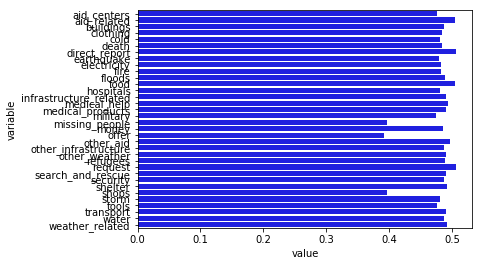

In [285]:
df_tools.message.iloc[0]
pred_proba = ml_pipeline_best.predict_proba(df_tools.message.iloc[0])
#sns.barplot(x="day", y="total_bill", data=tips)
df2 = pd.melt(pd.DataFrame({i:j[:,1] for i,j in zip(df.iloc[:,4:].columns, pred_proba)}))
print(df2.head())
sns.barplot(x='value', y='variable', data=df2, color='blue')

In [249]:
df_tools[['message','prediction']] # the class tools is not well-defined

,message,prediction
84,"Please we need help, food and toiletries.",0
310,we are in need of food tentes corvers water mo...,0
357,Emergency aid needed at the Centre Flore for D...,0
775,i have a problem talking to people in port au ...,0
906,We've found some fifty houses which suffered m...,0
1306,I would like information on the earthquake. Wh...,1
1496,Please help me I have nothing to survive. I ca...,0
1884,how long will the aftershocks last?,1
1997,"In the city of Marchand Dessalines, we need fo...",0
2126,"I am place dessaline, near the champ de mars, ...",0


### 9. Export your model as a pickle file

In [201]:


filename='data/ml_pipeline_best.pkl'
pickle.dump(ml_pipeline_best, open(filename,'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

## Code Bank

In [ ]:
# beautiful solution
df.message.apply(lambda x: " ".join([stemmer.stem(word) for word in re.sub("[^a-zA-Z]", " ", x).split() 
          if word not in stop_words]) )

In [ ]:
class Select_features(BaseEstimator, TransformerMixin):
    # constructor
    def __init__(self, column_names):
        self.column_names = column_names 
    
    # pipeline must implement fit
    def fit(self, X=None, y=None):
        return self
    
    # return new dataframe with selected features
    def transform(self, X=None, y=None):
        return X[self.column_names] 

In [ ]:
X = vector_features
y = MultiLabelBinarizer().fit_transform(labels)
print(len(labels))
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=32)

vectorizer = CountVectorizer(min_df= 5,stop_words="english", ngram_range=(1, 2))
clf = OneVsRestClassifier(BernoulliNB())
message_pipeline = Pipeline([('vectorizer', vectorizer),('clf',clf)])
message_pipeline.fit()
message_pipeline.named_steps['vectorizer'].transform([df_clean_message])